## Score-based Generative Modeling



In [5]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

### Fisher Divergence

Distance metric between gradient w.r.t $x$ of two distributions $p(x)$ and $q(x)$
$$
    \mathbb{E}_{x \sim q(x)}[||\nabla_x \log p(x) - \nabla_x \log q(x)||_2^2]
$$

Suppose $p(x)$ is the unknown data distribution, and we use a neural network $q(x)$ to estimate this unknown distribution, then using gradient descent on $x$ rather than the weights, we can update $x$ such that we get an $x$ that is approximately sampled from $p(x)$ by reducing the Fisher divergence. 

In [6]:
# general formula for a univariate Gaussian
def gaussian(x, mu, sigma):
    return 1/(sigma * (2*torch.pi)**0.5) * torch.exp(-.5 * (x-mu)**2 / sigma**2)

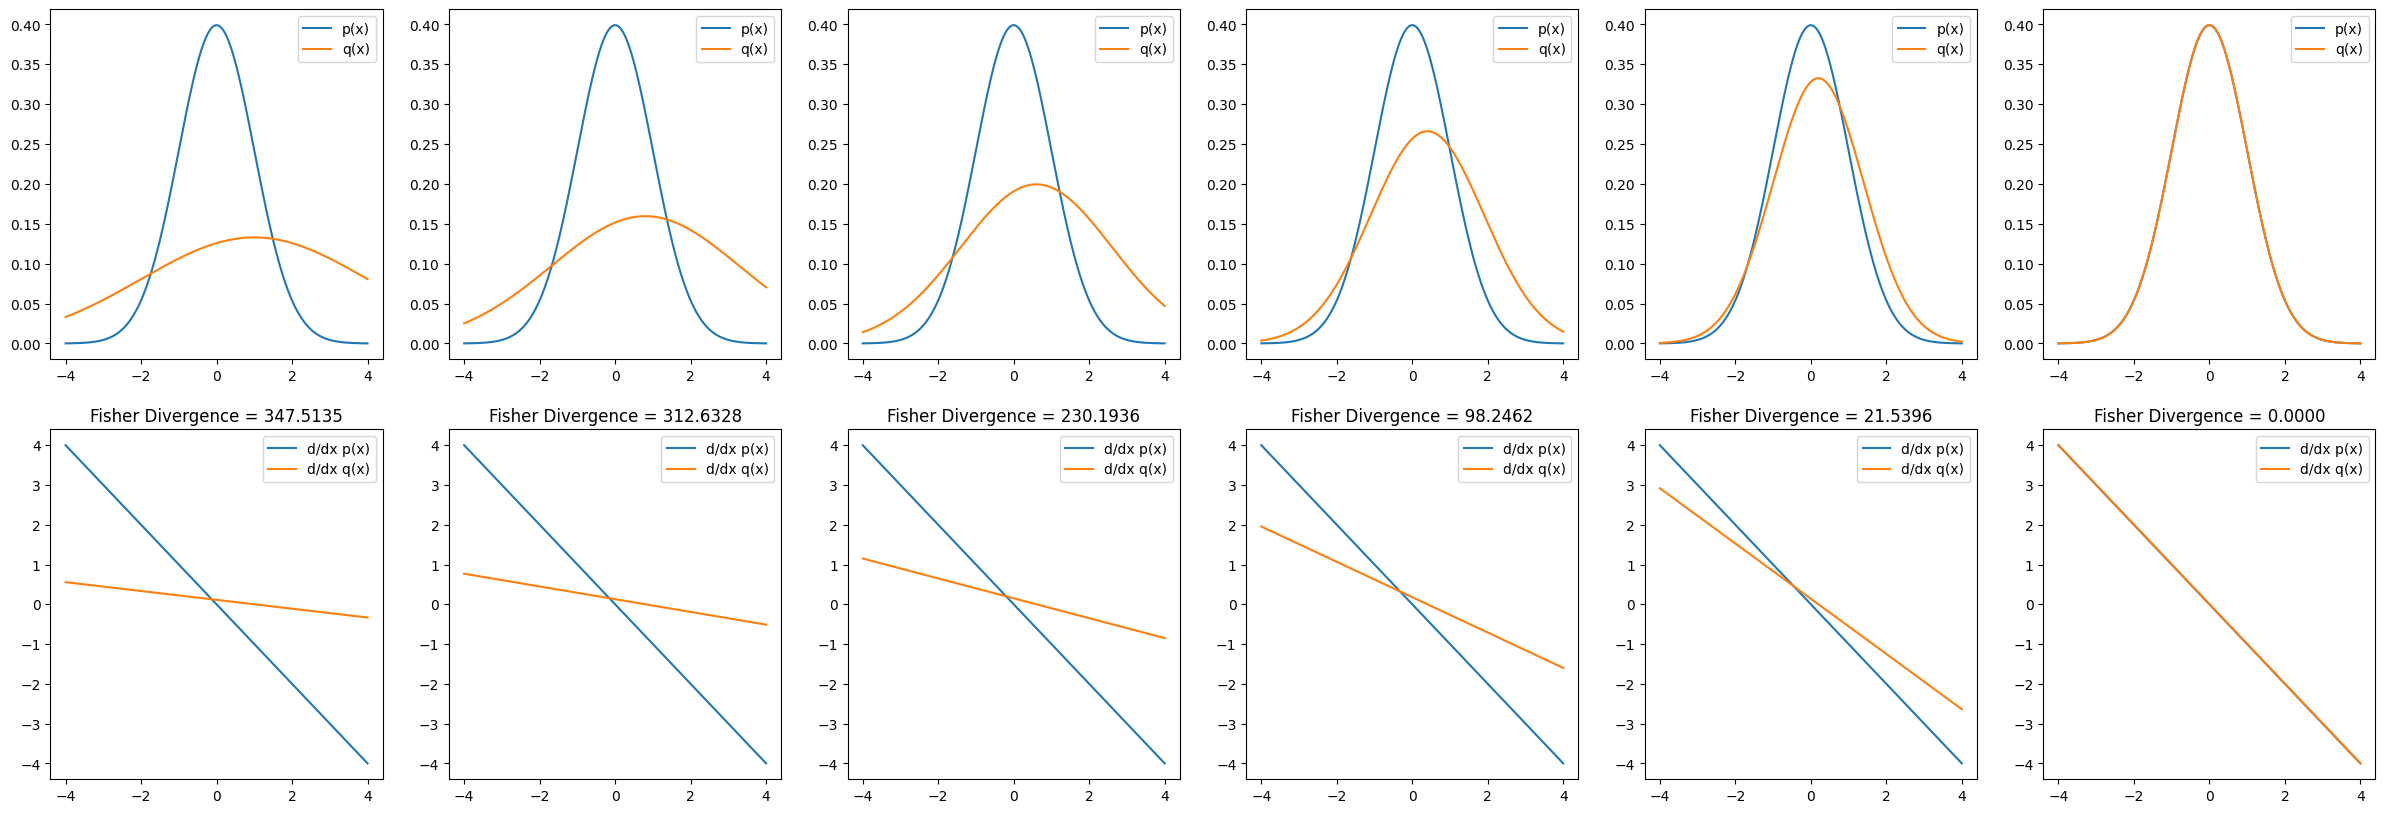

In [7]:
# define a linear range of values between -4 and 4 
x = torch.linspace(-4, 4, 1000, requires_grad=True)

p_mu = 0
p_var = 1
q_mus = [1, 0.8, 0.6, 0.4, 0.2, 0]
q_vars = [3, 2.5, 2, 1.5, 1.2, 1]

_, axes = plt.subplots(2, 6, figsize=(30, 10))

for q_mu, q_var, ax_row in zip(q_mus, q_vars, axes.T):
    # reset gradient to zero
    x.grad = None
    
    # constant p(x)
    p = gaussian(x, p_mu, p_var)
    log_p = torch.log(p)
    log_p.backward(torch.ones_like(log_p))
    ax_row[1].plot(x.detach().numpy(), x.grad.data, label='d/dx p(x)')
    deriv_log_p = x.grad.data.clone()
    
    # reset gradient to zero
    x.grad = None
    
    # varying q(x)
    q = gaussian(x, q_mu, q_var)
    log_q = torch.log(q)
    log_q.backward(torch.ones_like(log_q))
    ax_row[1].plot(x.detach().numpy(), x.grad.data, label='d/dx q(x)')
    deriv_log_q = x.grad.data.clone()
    
    # distance between gradients
    fisher_divergence = torch.sum(q * (deriv_log_p - deriv_log_q)**2)
    
    ax_row[1].set_title(f'Fisher Divergence = {fisher_divergence:.4f}')
    ax_row[1].legend()
    
    ax_row[0].plot(x.detach().numpy(), p.detach().numpy(), label='p(x)')
    ax_row[0].plot(x.detach().numpy(), q.detach().numpy(), label='q(x)')
    ax_row[0].legend()
    

### Load MNIST

In [216]:
import torchvision
import torchvision.transforms as transforms

# define preprocessing transformations to dataset
transform = transforms.Compose([
    # transforms.Resize(32),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.ToTensor(),
])

# load training set
train_set = torchvision.datasets.MNIST(root="../datasets", train=True, download=True, transform=transform)

# load test/validation set
test_val_set = torchvision.datasets.MNIST(root="../datasets", train=False, download=True, transform=transform)

# split into separate test and validation sets
X_test_val, y_test_val = zip(*test_val_set)
X_test_val = torch.stack(X_test_val)
y_test_val = torch.tensor(y_test_val)

test_idx, val_idx = torch.utils.data.random_split(y_test_val, [5000, 5000])

X_test = X_test_val[test_idx.indices]
y_test = y_test_val[test_idx.indices]

X_val = X_test_val[val_idx.indices]
y_val = y_test_val[val_idx.indices]

(train_set.data.shape, train_set.targets.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([5000, 1, 28, 28]),
 torch.Size([5000]),
 torch.Size([5000, 1, 28, 28]),
 torch.Size([5000]))

### Gaussian Fourier Mapping for time steps $t$

Using [Gaussian Fourier features](https://arxiv.org/abs/2006.10739), we can make coordinate-based neural networks perform better at modeling low dimensions, thereby overcoming the spectral bias. Spectral bias refers to the difficulty of learning high-frequency functions. Specifically, we first sample $\textbf{\omega} \sim \mathcal{N}(\textbf{0}, s^2\textbf{I})$ for a chosen scale $s$. This $\textbf{\omega}$ is fixed for the model, i.e., not learnable. For a given time step $t$, the corresponding Gaussian random feature is defined as
$$
    \text{GRF}(t) = \text{concat}[\sin(2\pi \omega t); \cos(2\pi \omega t)]
$$

In [217]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim: int, scale: float=30.0):
        super(GaussianFourierProjection, self).__init__()
        # W ~ N(0, scale * I)
        # shape: (embed_size//2, )
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
        
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X shape: (batch_size, )
        
        # X (batch_size, 1) * W (1, embed_size//2) * 2 pi --> X_proj (batch_size, embed_size//2)
        X_proj = X[:, None] * self.W[None, :] * 2 * np.pi
    
        # output shape: (batch_size, embed_size)
        return torch.cat([torch.sin(X_proj), torch.cos(X_proj)], dim=-1)

batch_size, embed_size = 32, 64 
gfp = GaussianFourierProjection(embed_dim=embed_size)
x = torch.randn(batch_size)
gfp(x).shape

torch.Size([32, 64])

### Linear layer wrapper

Simple wrapper around `nn.Linear` so that we can add two more new dimensions to the output. Broadcasting can then be applied to add the linear transformation to the conv output. 

In [218]:
class LinearUnsqeezed(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(LinearUnsqeezed, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X shape: (batch_size, input_dim)
        # output shape: (batch_size, output_dim, 1, 1)
        return self.linear(X)[..., None, None]
    
batch_size, inp_dim, out_dim = 8, 32, 4 
dense = LinearUnsqeezed(input_dim=inp_dim, output_dim=out_dim)
x = torch.randn(batch_size, inp_dim)
x.shape, dense(x).shape

(torch.Size([8, 32]), torch.Size([8, 4, 1, 1]))

### Score net



In [219]:
class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""
    
    def __init__(self, marginal_prob_std, channels: list[int], embed_dim: int):
        """Initialize a time-dependent score-based network.

        Args:
          marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super(ScoreNet, self).__init__()
        
        self.marginal_prob_std = marginal_prob_std
        
        # Gaussian random feature embedding
        self.embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim), 
            nn.Linear(embed_dim, embed_dim)
        )
        
        # Encoder
        # first encoder block is different from the others
        encoder = [
            nn.ModuleList([
                nn.Conv2d(
                    in_channels=1, 
                    out_channels=channels[0], 
                    kernel_size=3, stride=1, bias=False),
                LinearUnsqeezed(embed_dim, channels[0]),
                nn.GroupNorm(num_groups=4, num_channels=channels[0])
            ])
        ]
        # each block convolves over input, adds linearly mapped gaussian time step feature, and performs group normalization 
        for channel_in, channel_out in zip(channels, channels[1:]):
            group = nn.ModuleList([
                nn.Conv2d(
                    in_channels=channel_in, 
                    out_channels=channel_out, 
                    kernel_size=3, stride=2, 
                    bias=False),
                
                LinearUnsqeezed(input_dim=embed_dim, 
                                output_dim=channel_out),
                
                nn.GroupNorm(num_groups = 32, num_channels=channel_out)
            ])
            encoder.append(group)
        self.encoder = nn.ModuleList(encoder)
        
        # Decoder
        decoder = []
        # last transposed conv layer differs from the rest
        self.last_tconv2d = nn.ConvTranspose2d(
            in_channels=channels[0] + channels[0], 
            out_channels=1, 
            kernel_size=3, stride=1)
        
        for i, (channel_in, channel_out) in enumerate(zip(reversed(channels), reversed(channels[:-1]))):
            
            group = nn.ModuleList([
                nn.ConvTranspose2d(
                    in_channels=channel_in + channel_in if i != 0 else channel_in, 
                    out_channels=channel_out, 
                    kernel_size=3, stride=2, 
                    bias=False,
                    output_padding=1 if i != 0 else 0
                ),
                
                LinearUnsqeezed(input_dim=embed_dim, 
                                output_dim=channel_out),
                
                nn.GroupNorm(num_groups = 32, num_channels=channel_out)
            ])
            decoder.append(group)
        self.decoder = nn.ModuleList(decoder)
        
        # Swish-1 activation function
        self.act = lambda x: x * torch.sigmoid(x)
    
    def forward(self, X: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        
        embedding = self.act(self.embed(t))
        skip_connections = []
        
        # encoder
        for conv, linear, batch_norm in self.encoder:
            X = conv(X)
            X += linear(embedding)
            X = batch_norm(X)
            X = self.act(X)
            skip_connections.append(X.clone())
        
        # decoder (with residual concatenations)
        for i, (H, (conv, linear, batch_norm)) in enumerate(zip(reversed(skip_connections), self.decoder)):
            # no concat if i == 0 because that's just cat([X, X], dim=1)
            X = conv(X if i == 0 else torch.cat([X, H], dim=1))
            X += linear(embedding)
            X = X if batch_norm is None else batch_norm(X)
            X = self.act(X)
        
        X = self.last_tconv2d(torch.cat([X, skip_connections[0]], dim=1))
        
        # normalize by dividing by standard deviation of perturbed X
        y = X / self.marginal_prob_std(t)[:, None, None, None]
        
        return y

# test
net = ScoreNet(lambda x: x, [32, 64, 128, 256], embed_dim=256)
x = torch.randn(64, 1, 28, 28)
t = torch.randn(64,)
net(x, t).shape

torch.Size([64, 1, 28, 28])

### Marginal probability scale

$$
    \sqrt{\dfrac{\sigma^{2t} - 1}{2 \log \sigma}}
$$

In [220]:
import functools

def marginal_prob_std(t: torch.Tensor, sigma: float) -> torch.Tensor:
    return torch.sqrt((sigma ** (2 * t) - 1.0) / 2.0 / np.log(sigma))

def diffusion_coeff(t: torch.Tensor, sigma: float): 
    return sigma**t

sigma = 25
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

$$
    \frac{\sigma^{2t} - 1}{2 \log \sigma} s_{\theta}(\tilde{X}) + Z
$$

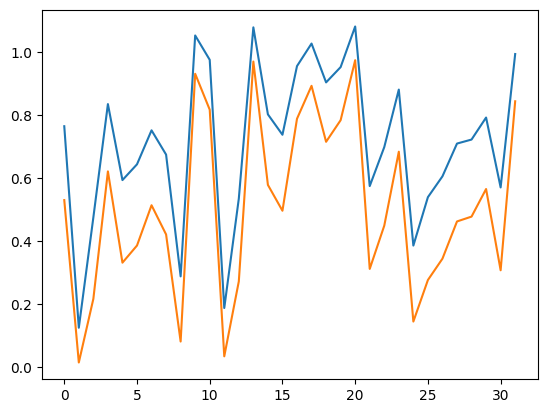

In [211]:
t = torch.rand(32)
m = marginal_prob_std(t, 1.2)

plt.plot(m)
plt.plot(t)


### Loss function

Given mini-batch $X$, perturb via
$$
    \tilde{X}_t = X + \sqrt{\dfrac{\sigma^{2t} - 1}{2 \log \sigma}} Z
$$
where $Z \sim \mathcal{N}(\textbf{0}, \textbf{I})$. The estimate for the gradient of the log data distribution $\nabla_X p_{\text{data}}(X)$ is given by
$$
    s_{\textbf{\theta}}(X_t, t)
$$
and parameterized by a U-net. The loss is then
$$
    \mathbb{E}_{t \sim \mathcal{U}(0, T)} \mathbb{E}_{X \sim p_t(X)}\left[\left(Z + s_{\textbf{\theta}}(X_t, t) \sqrt{\dfrac{\sigma^{2t} - 1}{2 \log \sigma}}\right)^2\right]
$$

In [221]:
def loss_fn(model: nn.Module, X: torch.Tensor, marginal_prob_std, eps: float=1e-5) -> torch.Tensor:
    
    batch_size = X.shape[0]
    random_t = torch.rand(batch_size).to(X.device)
    Z = torch.randn_like(X)
    std = marginal_prob_std(random_t)
    
    perturbed_X = X + Z * std[:, None, None, None]
    score = model(perturbed_X, random_t)
    
    loss = torch.sum((score * std[:, None, None, None] + Z)**2, dim=(1, 2, 3)).mean()
    return loss

In [222]:
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-4
EMBED_DIM = 256
CHANNELS = [32, 64, 128, 256]

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [223]:
from torch.utils.data import DataLoader

data_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

model = ScoreNet(
    marginal_prob_std=marginal_prob_std_fn, 
    channels=CHANNELS,
    embed_dim=EMBED_DIM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

training_loss = []


Epoch: 0	Training loss: 276.0355
Epoch: 1	Training loss: 65.3611
Epoch: 2	Training loss: 45.0038
Epoch: 3	Training loss: 35.8233
Epoch: 4	Training loss: 30.9434
Epoch: 5	Training loss: 28.2587
Epoch: 6	Training loss: 26.1690
Epoch: 7	Training loss: 24.6203
Epoch: 8	Training loss: 23.5653
Epoch: 9	Training loss: 22.8741
Epoch: 10	Training loss: 21.9464
Epoch: 11	Training loss: 21.4830
Epoch: 12	Training loss: 21.1382
Epoch: 13	Training loss: 20.5857
Epoch: 14	Training loss: 20.3869
Epoch: 15	Training loss: 20.0154
Epoch: 16	Training loss: 19.8784
Epoch: 17	Training loss: 20.0011
Epoch: 18	Training loss: 19.3603
Epoch: 19	Training loss: 19.2387
Epoch: 20	Training loss: 19.2295
Epoch: 21	Training loss: 18.8702
Epoch: 22	Training loss: 18.6594
Epoch: 23	Training loss: 18.6094
Epoch: 24	Training loss: 18.5974
Epoch: 25	Training loss: 18.3790
Epoch: 26	Training loss: 18.1056
Epoch: 27	Training loss: 18.3404
Epoch: 28	Training loss: 17.9824
Epoch: 29	Training loss: 18.0671
Epoch: 30	Training 

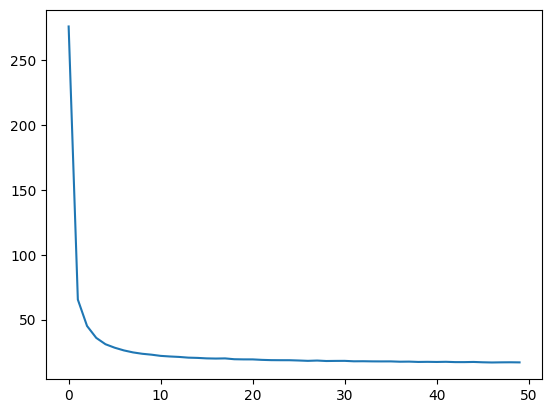

In [224]:

for epoch in range(EPOCHS):

    batch_loss, n_items = 0, 0
    for X, y in data_loader:
        X = X.to(DEVICE)
        
        loss = loss_fn(model, X, marginal_prob_std_fn)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss += loss.item() * X.shape[0]
        n_items += X.shape[0]
        
    training_loss.append(batch_loss / n_items)
    print(f"Epoch: {epoch}\tTraining loss: {training_loss[-1]:.4f}")
    
plt.plot(training_loss)

In [237]:
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=500, 
                           device='cuda', 
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  
  diffused_X = []
  with torch.no_grad():
      for time_step in time_steps:      
          batch_time_step = torch.ones(batch_size, device=device) * time_step
          g = diffusion_coeff(batch_time_step)
          mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
          x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
          diffused_X.append(mean_x)
    
  # Do not include any noise in the last sampling step.
  return mean_x, diffused_X

In [240]:
x_sample, diffused_x = Euler_Maruyama_sampler(model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size=BATCH_SIZE, num_steps=500, device=DEVICE, eps=1e-3)

x_sample.shape, len(diffused_x)

(torch.Size([32, 1, 28, 28]), 500)

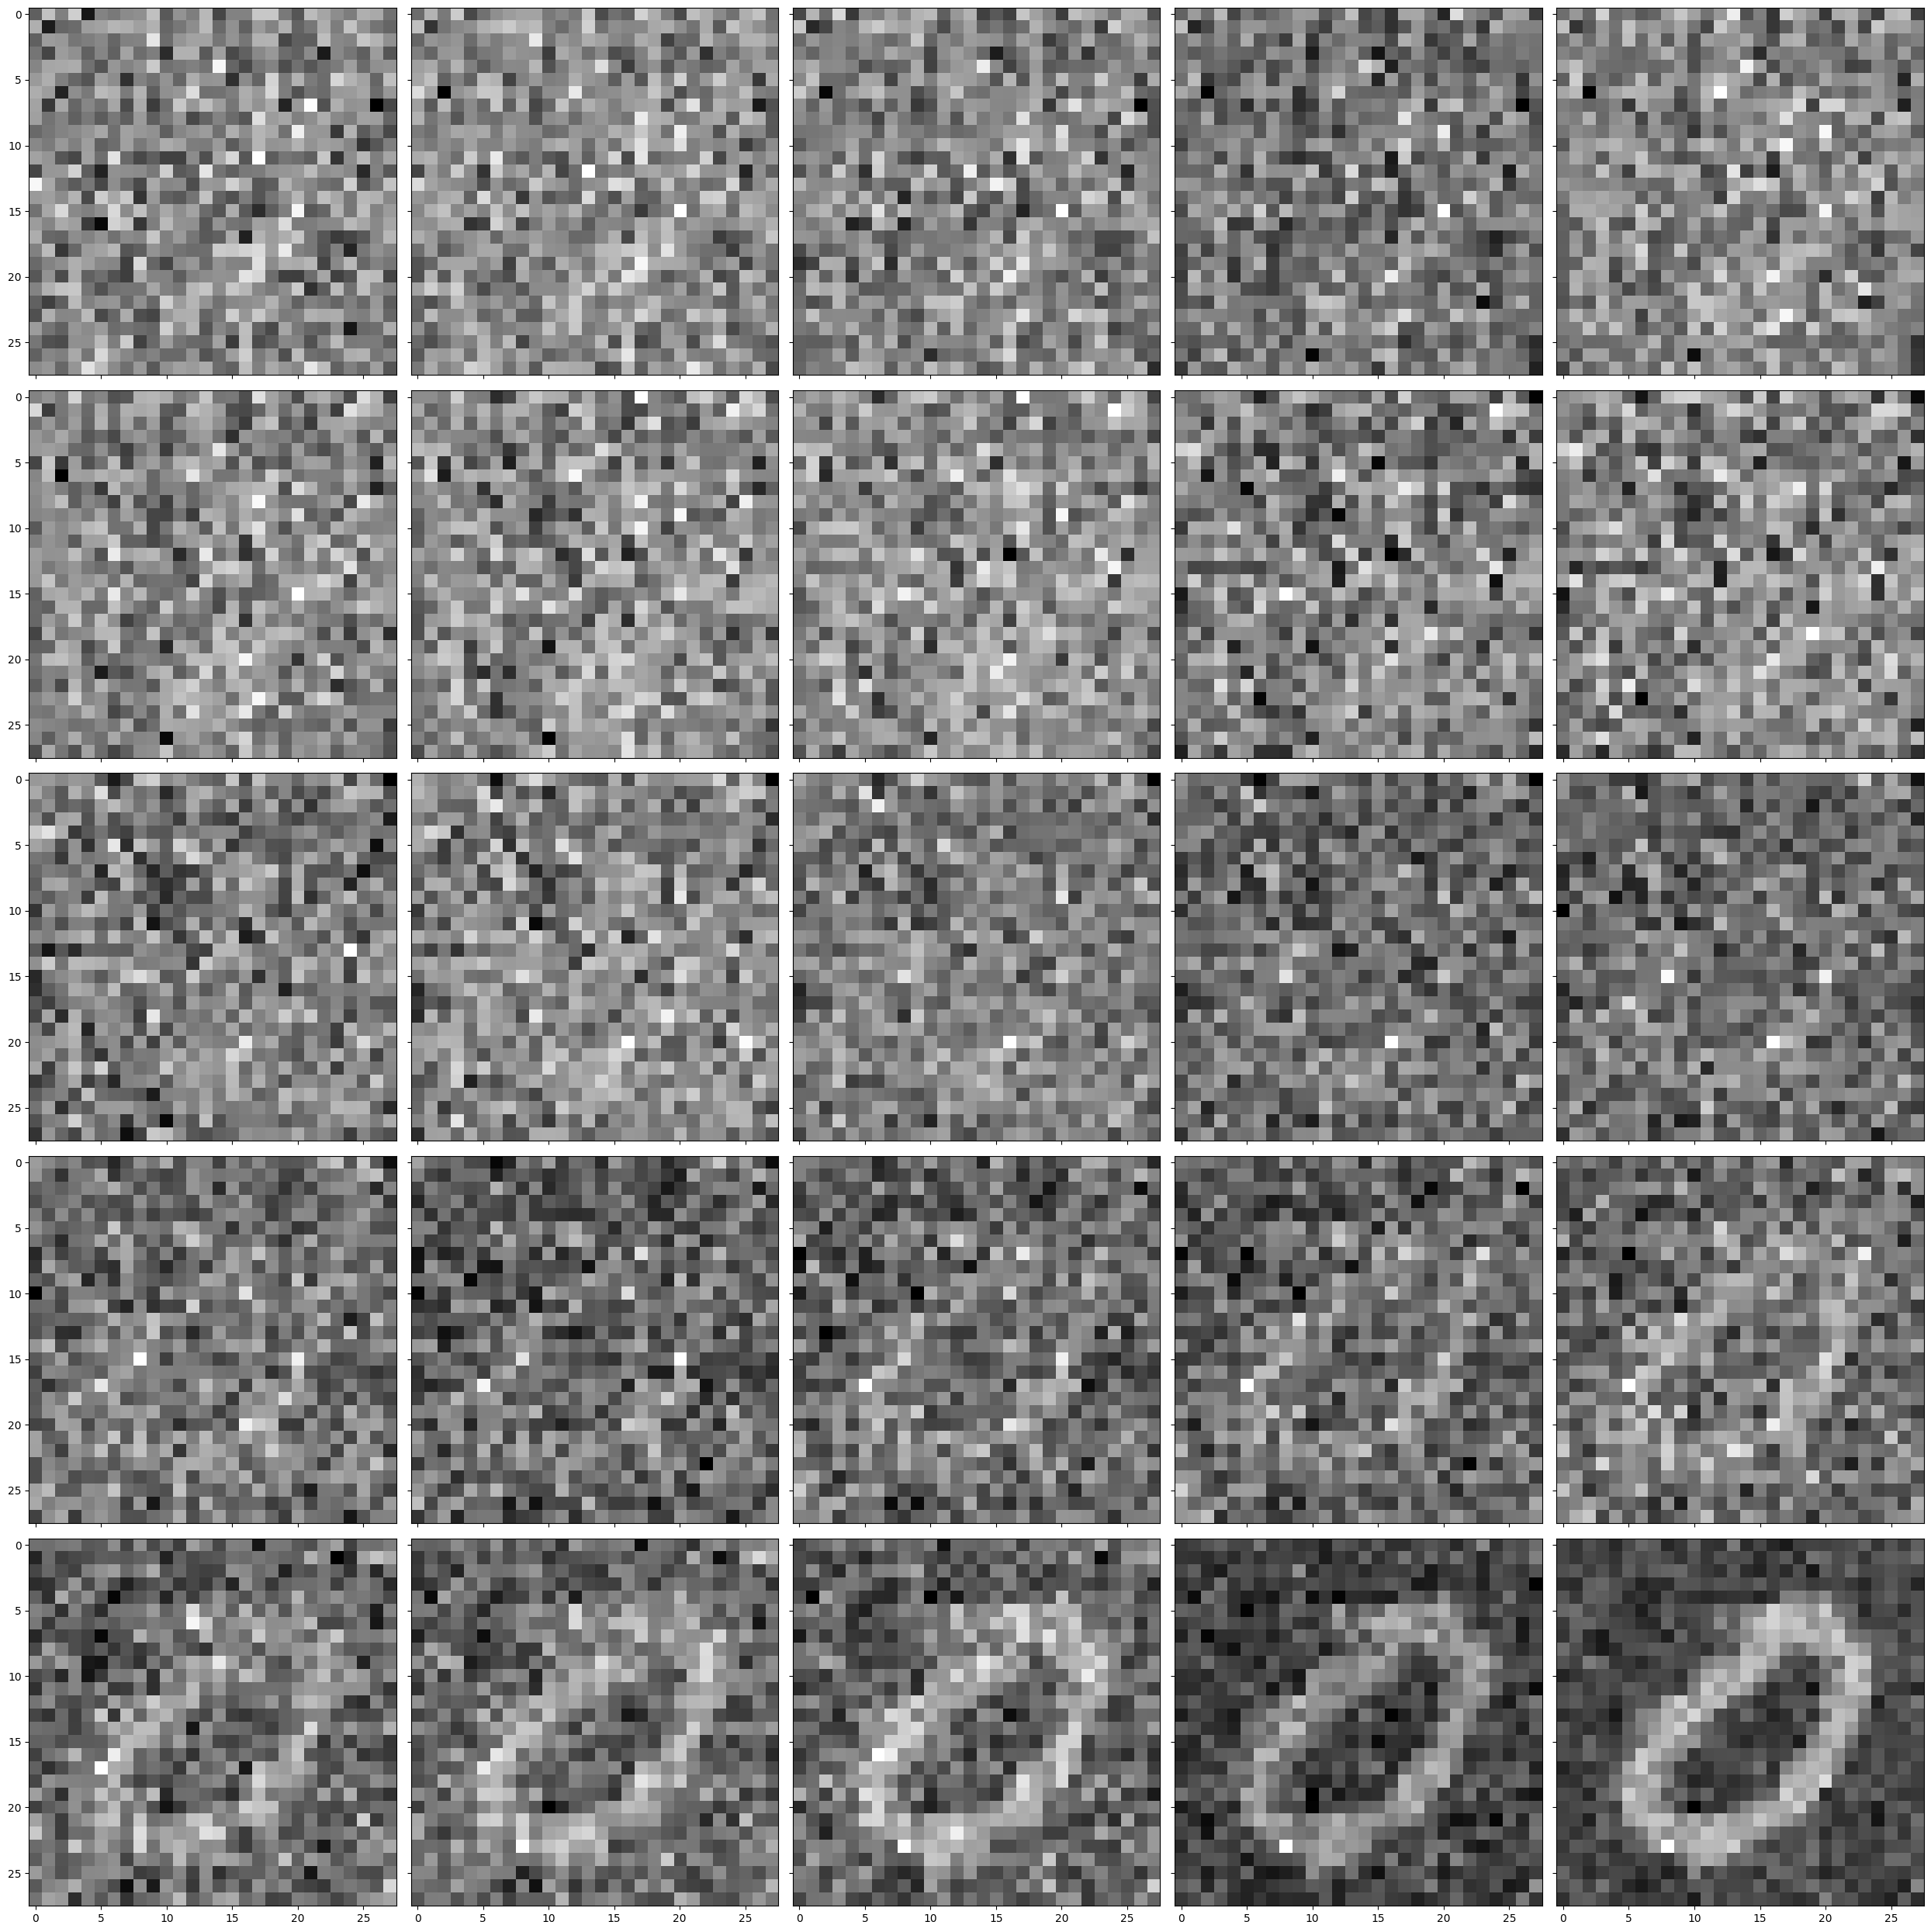

In [246]:
_, axes = plt.subplots(5, 5, figsize=(25, 25), sharex=True, sharey=True)
axes = axes.flatten()

for ax, diff_x in zip(axes, diffused_x[::20]):
    ax.imshow(diff_x[3, 0].cpu().numpy(), cmap='gray')

plt.tight_layout()

KeyboardInterrupt: 

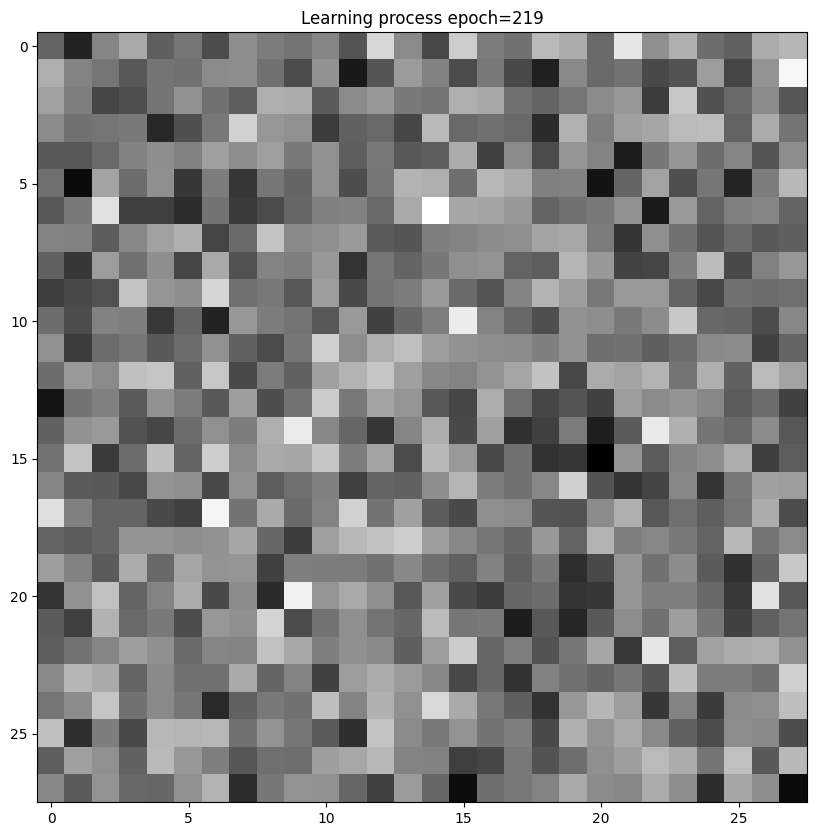

In [248]:
from matplotlib import animation

fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
# ax.set_xlabel(r'$h_1$')
# ax.set_ylabel(r'$h_2$')
# sc = ax.scatter([], [])

def animate(i):
    # global sc
    ax.imshow(diffused_x[i][0, 0].cpu().numpy(), cmap='gray')
    ax.set_title(f'Learning process epoch={i}')
    return 

anim = animation.FuncAnimation(fig, animate, frames=len(diffused_x), repeat=False, interval=5)
anim.save('../outputs/scorenet_diffusion_process.mp4', writer=animation.FFMpegWriter(fps=30))

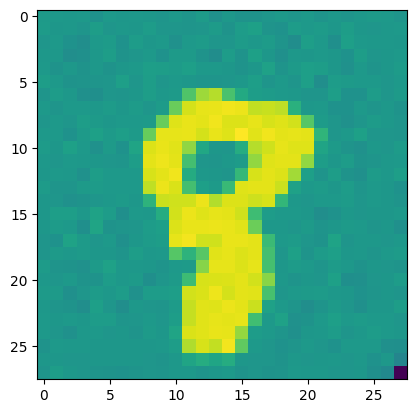

In [236]:
plt.imshow(x_sample[6, 0].cpu().numpy())